# Corrective Rag(CRAG) using local LLMS

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

The logic follows this general flow:

- If at least one document exceeds the threshold for relevance, then it proceeds to generation
- If all documents fall below the relevance threshold or if the grader is unsure, then it uses web search to supplement retrieval
Before generation, it performs knowledge refinement of the search or retrieved documents
- This partitions the document into knowledge strips
It grades each strip, and filters out irrelevant ones
We will implement some of these ideas from scratch using LangGraph:

- If any documents are irrelevant, we'll supplement retrieval with web search.
We'll skip the knowledge refinement, but this can be added back as a node if desired.
We'll use Tavily Search for web search.

In [1]:
import getpass 
import os 
from dotenv import load_dotenv

load_dotenv()

GROK_API_KEY = os.getenv("GROK_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
HG_FACE_API_KEY = os.getenv("HG_FACE_API_KEY")

In [2]:
import ollama 
available_models = ollama.list()
available_models

ListResponse(models=[Model(model='wizardlm2:latest', modified_at=datetime.datetime(2025, 3, 1, 23, 49, 4, 295170, tzinfo=TzInfo(+03:00)), digest='c9b1aff820f245a43b1719b296ce7131746073691cbb56f7a8d88a4713a3df79', size=4108928625, details=ModelDetails(parent_model='', format='gguf', family='llama', families=['llama'], parameter_size='7B', quantization_level='Q4_0')), Model(model='mxbai-embed-large:latest', modified_at=datetime.datetime(2025, 3, 1, 23, 43, 45, 523887, tzinfo=TzInfo(+03:00)), digest='468836162de7f81e041c43663fedbbba921dcea9b9fefea135685a39b2d83dd8', size=669615493, details=ModelDetails(parent_model='', format='gguf', family='bert', families=['bert'], parameter_size='334M', quantization_level='F16')), Model(model='nomic-embed-text:latest', modified_at=datetime.datetime(2025, 2, 25, 15, 1, 57, 368958, tzinfo=TzInfo(+03:00)), digest='0a109f422b47e3a30ba2b10eca18548e944e8a23073ee3f3e947efcf3c45e59f', size=274302450, details=ModelDetails(parent_model='', format='gguf', family=

In [3]:
# local_llm = "llama3.2:latest"
local_llm = "qwen2.5:latest"
model_tested = "llama3.2:latest"
metadata = f"CRAG, {model_tested}"

# Creating Index or Vector store 

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore, Chroma
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings


# URL list to scrape

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# load documents from url 
docs = [WebBaseLoader(url).load() for url in urls]
docs_lists = [item for sublist in docs for item in sublist] # Basically flatten the list

# Initialize a text splitter with specified chunksize and overlap 

test_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 250,
    chunk_overlap = 10
)

# Split the documents into smaller chunks 
doc_splits = test_splitter.split_documents(docs_lists)
print(f"Number of documents: {len(docs_lists)}")
print(f"Number of splits: {len(doc_splits)}")
# print(f"First split: {doc_splits[0].page_content}")
# print(f"First document: {docs_lists[0].page_content}")

# Embeddings 

embedding = OllamaEmbeddings(model="chroma/all-minilm-l6-v2-f32:latest")

vectorstore = Chroma.from_documents(
    documents = doc_splits,
    collection_name = "rag_chroma",
    embedding = embedding
)


retriever = vectorstore.as_retriever(  search_type="mmr",
        search_kwargs={'k': 5})

USER_AGENT environment variable not set, consider setting it to identify your requests.


Number of documents: 3
Number of splits: 195


In [6]:
# Define Tools
### Retrieval Grader 

from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model=local_llm, format="json", temperature=0, num_ctx=4000)

# Prompt 
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"

docs = retriever.invoke(question)

# doc_txt = docs[0].page_content

print(retrieval_grader.invoke({"question": question, "documents": docs}))


{'score': 'Yes'}


In [7]:
### Generate 
from langchain_core.output_parsers import StrOutputParser

# Prompt 
prompt = PromptTemplate(
    template = """You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM 
llm = ChatOllama(model=local_llm, temperature=0, num_ctx=4000)

# Chain 
rag_chain = prompt | llm | StrOutputParser()

# Runnning 
query = "what are the types of agent memory?"
generation = rag_chain.invoke({"documents": docs, "question": query})
print(generation)

The types of agent memory include short-term memory and long-term memory. Short-term memory is used for in-context learning, while long-term memory allows the agent to retain and recall information over extended periods by leveraging an external vector store.


In [8]:
# Searching tool
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3, TAVILY_API_KEY=TAVILY_API_KEY)

## Ceating the Graph

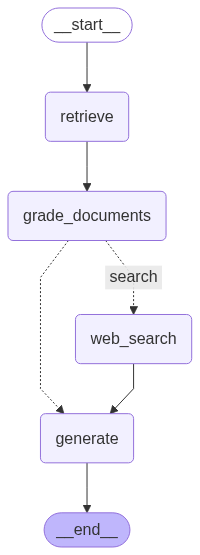

In [9]:
from typing import List 
from typing_extensions import TypedDict
from IPython.display import Image, display 
from langchain.schema import Document 
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """ 
    Respresents the state of our graph 

    Attributes:
    question: question
    generation: LLM generation 
    search: whether to add search 
    documents: list of documents
    """

    question: str
    generation: str
    search: str 
    documents: List[str]
    steps: List[str]

def retrieve(state):
     """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
     question = state["question"]
     documents = retriever.invoke(question)
     steps = state["steps"]
     steps.append("retrieve_document")
     return {
         "documents": documents, "question": question, "steps": steps
     }

def generate(state):
    """
    Generate answers
    
    Args: 
       state (dict): The current graph state

    Returns:
        state (dics): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")

    return {
        "documenst": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state(dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "Yes":
            filtered_docs.append(d)
        else:
            search = "yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps
    }

def web_search(state):
     """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
     
     question = state["question"]
     documents = state.get("documents", [])
     steps = state["steps"]
     steps.append("web_search")
     web_results = web_search_tool.invoke({"query": "question"})
     documents.extend(
         [
             Document(page_content=d["content"], metadata={"url": d["url"]})
             for d in web_results
         ]
     )

     return {
         "documents": documents, "question": question, "steps": steps
     }

def decide_to_generate(state):
     """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
     search = state["search"]
     if search == "Yes":
         return search
     else:
         return "generate"
     
# Graph 
workflow = StateGraph(GraphState)

# Define the nodes 
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate 
workflow.add_node("web_search", web_search)

# Build graph 

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    }
)

workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))


In [10]:
import uuid 

def predict_custom_agent_local_answe(example: dict):
    config = {"configuration": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    ) 

    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

example = {"input": "what are the types of agent memory?"}

response = predict_custom_agent_local_answe(example)
response 

{'response': 'The types of agent memory include short-term memory and long-term memory. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods using an external vector store.',
 'steps': ['retrieve_document', 'grade_document_retrieval', 'generate_answer']}